In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
import requests
import io
proxy_dict = {
    'http': "http://J0438567@10.16.152.74:8080",
    'https': "http://J0438567@10.16.152.74:8080"
}

In [2]:
def correct(df_raw):
    """Erreur sur les données de septembre en Essonne"""
    df_ess = df_raw[df_raw['dep']=='91'].reset_index().set_index('jour')
    idxmax = df_ess['incid_hosp'].idxmax()
    # Hosp
    df_ess.loc[:idxmax, 'incid_hosp'] += 1
    df_ess.loc[idxmax, 'incid_hosp'] -= len(df_ess[:idxmax])
    reste = df_ess['incid_hosp'][idxmax] - 27
    df_ess.loc[:idxmax, 'incid_hosp'].iloc[-reste:] += 1
    df_ess.loc[idxmax, 'incid_hosp'] -= len(df_ess[:idxmax][-reste:])
    # Dc
    reste = df_ess['incid_dc'][idxmax] - 1
    df_ess.loc[:idxmax, 'incid_dc'].iloc[-reste:] += 1
    df_ess.loc[idxmax, 'incid_dc'] -= len(df_ess[:idxmax][-reste:])
    df_raw.loc[df_raw['dep']=='91'] = df_ess.reset_index().set_index('index')
    return df_raw

In [3]:
url = "https://www.data.gouv.fr/fr/datasets/r/6fadff46-9efd-4c53-942a-54aca783c30c"
req = requests.get(url, proxies=proxy_dict).text
df_raw = pd.read_csv(io.StringIO(req), sep=';', parse_dates=['jour'])
df_raw = correct(df_raw)
df = df_raw.groupby('jour').sum()
df['pos_semaine'] = df.index.weekday
if df['pos_semaine'].iloc[-1] < 5:
    df_util = df[df['pos_semaine']<5].resample('W').mean()
else:
    df_util = df.resample('W').mean()

In [4]:
df[:'2020-07'].sum()

incid_hosp     115073
incid_rea       18374
incid_dc        20204
incid_rad       85833
pos_semaine       406
dtype: int64

In [5]:
df['2020-08':].sum()

incid_hosp     221102
incid_rea       34364
incid_dc        37047
incid_rad      157724
pos_semaine       579
dtype: int64

In [6]:
df.tail()

,incid_hosp,incid_rea,incid_dc,incid_rad,pos_semaine
jour,,,,,
2021-02-05,1719,255,296,1590,4
2021-02-06,1126,168,191,1147,5
2021-02-07,790,160,171,291,6
2021-02-08,1893,356,460,1043,0
2021-02-09,1931,334,439,1764,1


In [7]:
(df_util.diff() / df_util.shift(1)).tail(5)

,incid_hosp,incid_rea,incid_dc,incid_rad,pos_semaine
jour,,,,,
2021-01-17,0.072140,-0.019114,-0.063492,-0.036315,0.00
2021-01-24,0.169168,0.225864,0.202712,0.140882,0.00
2021-01-31,0.007507,0.085983,0.046223,-0.036061,0.00
2021-02-07,0.003347,-0.007319,0.009698,0.140993,0.00
2021-02-14,0.028842,0.156166,0.199306,-0.033269,-0.75


In [8]:
def get_df_dept(df_raw, departements: list=None):
    df_raw_dept = df_raw[df_raw['dep'].isin(departements)]
    df_dept = df_raw_dept.groupby('jour').sum()
    df_dept['pos_semaine'] = df_dept.index.weekday
    df_dept = df_dept[df_dept['pos_semaine']<5].resample('W').mean()
    if df_dept['pos_semaine'].iloc[-1] < 5:
        df_util_dept = df_dept[df_dept['pos_semaine']<5].resample('W').mean()
    else:
        df_util_dept = df_dept.resample('W').mean()
    return df_util_dept

In [9]:
idf_util = get_df_dept(df_raw, ['75', '77', '78', '91', '92', '93', '94', '95'])

In [10]:
df_util['incid_dc'].idxmax()

Timestamp('2020-04-12 00:00:00', freq='W-SUN')

In [11]:
df_util['incid_dc'].max()

556.8

In [26]:
def annote(df, col):
    x_max1 = df.loc[:'2020-07', col].idxmax()
    y_max1 = df.loc[:'2020-07', col].max()
    plt.annotate(str(int(y_max1)), (x_max1, y_max1), xytext=(x_max1, y_max1*2), arrowprops={'arrowstyle': 'simple'}, fontsize=30)
    x_max2 = df.loc['2020-07':'2020-12', col].idxmax()
    y_max2 = df.loc['2020-07':'2020-12', col].max()
    plt.annotate(str(int(y_max2)), (x_max2, y_max2), xytext=(x_max2, y_max2*2), arrowprops={'arrowstyle': 'simple'}, fontsize=30)
    x_min = df[col].idxmin()
    y_min = df[col].min()
    plt.annotate(str(int(y_min)), (x_min, y_min), xytext=(x_min, y_min*2), arrowprops={'arrowstyle': 'simple'}, fontsize=30)
    x_last = df.index[-1]
    y_last = df[col].iloc[-1]
    plt.annotate(str(int(y_last)), (x_last, y_last), xytext=(x_last, y_last*2), arrowprops={'arrowstyle': 'simple'}, fontsize=30)

In [35]:
def display_covid_graph(df, place_name=""):
    plt.figure(figsize=(24, 10))
    sns.set_style("whitegrid")
    sns.lineplot(data=df['incid_hosp'], linewidth=3, dashes=False, color='red', label='Hospitalisations')
    sns.lineplot(data=df['incid_rea'], linewidth=3, dashes=False, color='orange', label='Admissions en réanimation')
    sns.lineplot(data=df['incid_dc'], linewidth=3, dashes=False, color='black', label="Décès à l'hôpital")
    plt.title("Données hospitalières"+place_name+", liées au coronavirus, quotidiennes moyennées sur la semaine", {'fontsize': 30})
    plt.legend(fontsize=20, loc='upper center')
    plt.yscale('log')
    plt.grid(which='minor', axis='y')
    plt.rc('ytick',labelsize=20)
    plt.rc('xtick',labelsize=20)

    for col in ['incid_dc', 'incid_rea', 'incid_hosp']:
        annote(df, col)

    plt.xlabel('Date', {'fontsize': 20})
    plt.ylabel('Nombre quotidien de nouveaux patients', {'fontsize': 20})

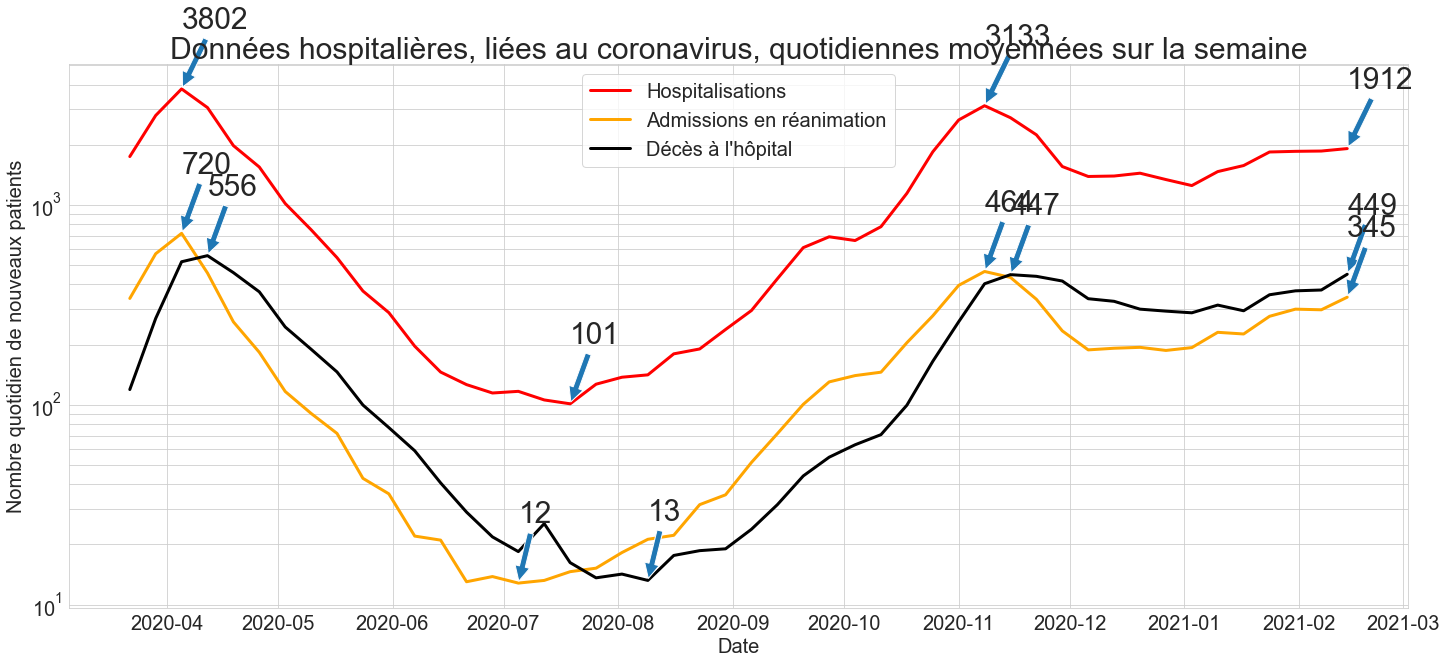

In [36]:
display_covid_graph(df_util)
plt.savefig('complet.png')

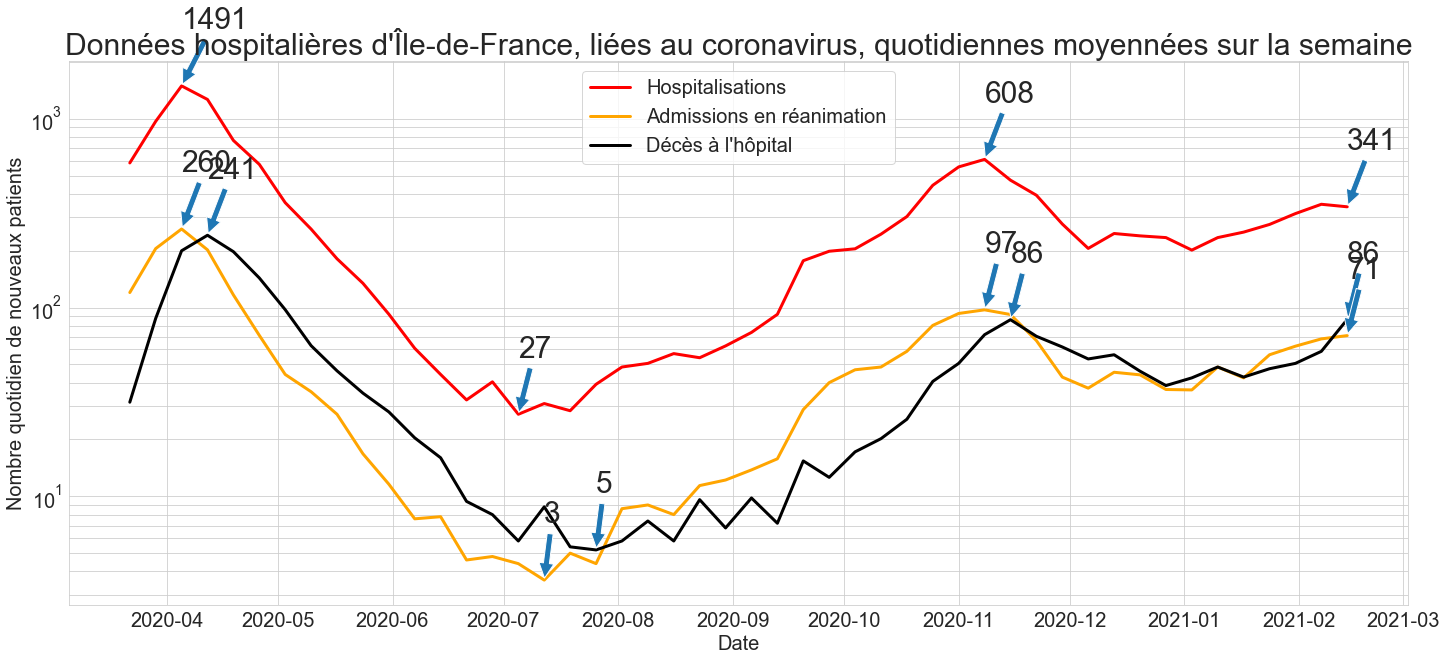

In [37]:
display_covid_graph(idf_util, " d'Île-de-France")
plt.savefig('idf.png')

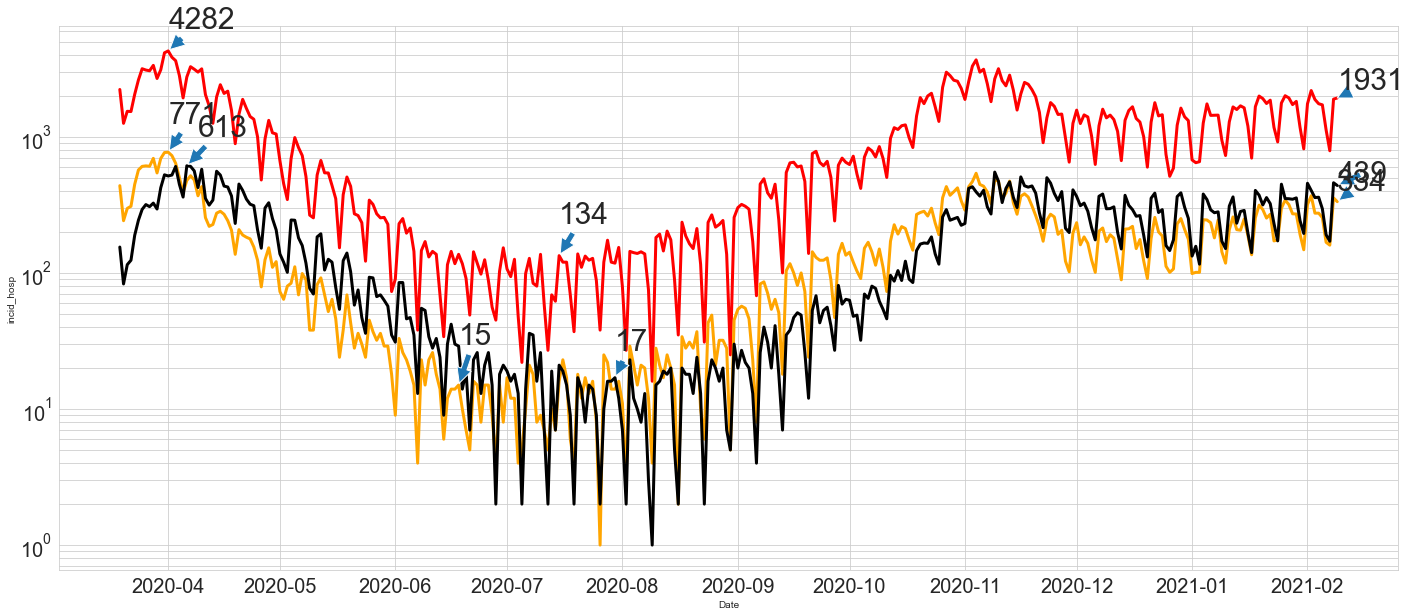

In [30]:
plt.figure(figsize=(24, 10))
sns.set_style("whitegrid")
sns.lineplot(data=df['incid_hosp'], linewidth=3, dashes=False, color='red')
sns.lineplot(data=df['incid_rea'], linewidth=3, dashes=False, color='orange')
sns.lineplot(data=df['incid_dc'], linewidth=3, dashes=False, color='black')
plt.yscale('log')
plt.grid(which='minor', axis='y')
plt.rc('ytick',labelsize=20)
plt.rc('xtick',labelsize=20)
plt.annotate(str(df['incid_dc'].iloc[18]), (df.index[18], df['incid_dc'].iloc[18]), xytext=(df.index[21], df['incid_dc'].iloc[18]+400), arrowprops={'arrowstyle': 'simple'}, fontsize=30)
plt.annotate(str(df['incid_dc'].iloc[133]), (df.index[133], df['incid_dc'].iloc[133]), xytext=(df.index[133], df['incid_dc'].iloc[133]+10), arrowprops={'arrowstyle': 'simple'}, fontsize=30)
plt.annotate(str(df['incid_dc'].iloc[-1]), (df.index[-1], df['incid_dc'].iloc[-1]), xytext=(df.index[-1], df['incid_dc'].iloc[-1]+30), arrowprops={'arrowstyle': 'simple'}, fontsize=30)
plt.annotate(str(df['incid_hosp'].iloc[13]), (df.index[13], df['incid_hosp'].iloc[13]), xytext=(df.index[13], df['incid_hosp'].iloc[13]+2000), arrowprops={'arrowstyle': 'simple'}, fontsize=30)
plt.annotate(str(df['incid_hosp'].iloc[118]), (df.index[118], df['incid_hosp'].iloc[118]), xytext=(df.index[118], df['incid_hosp'].iloc[118]+100), arrowprops={'arrowstyle': 'simple'}, fontsize=30)
plt.annotate(str(df['incid_hosp'].iloc[-1]), (df.index[-1], df['incid_hosp'].iloc[-1]), xytext=(df.index[-1], df['incid_hosp'].iloc[-1]+300), arrowprops={'arrowstyle': 'simple'}, fontsize=30)
plt.annotate(str(df['incid_rea'].iloc[13]), (df.index[13], df['incid_rea'].iloc[13]), xytext=(df.index[13], df['incid_rea'].iloc[13]+500), arrowprops={'arrowstyle': 'simple'}, fontsize=30)
plt.annotate(str(df['incid_rea'].iloc[91]), (df.index[91], df['incid_rea'].iloc[91]), xytext=(df.index[91], df['incid_rea'].iloc[91]+15), arrowprops={'arrowstyle': 'simple'}, fontsize=30)
plt.annotate(str(df['incid_rea'].iloc[-1]), (df.index[-1], df['incid_rea'].iloc[-1]), xytext=(df.index[-1], df['incid_rea'].iloc[-1]+70), arrowprops={'arrowstyle': 'simple'}, fontsize=30)
plt.xlabel('Date')
plt.savefig('quotidien.png')